# 导包

In [73]:
import torch
import torchvision
import torch.nn
import torch.nn.init
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import collections
import pickle
import math

1.4.0
0.5.0
True


In [2]:
import nlp
import rnn
import basic
import data

In [3]:
import imp
imp.reload(nlp)

<module 'nlp' from 'C:\\Users\\bambo\\PycharmProjects\\ai_learning\\nlp.py'>

# 机器翻译及相关技术
机器翻译的特别之处在于输入和输出都是不定长的。

## 数据准备
### 读入文本
1. 读取文本
2. 替换法文空格为普通空格

字符在计算机里是以编码的形式存在，我们通常所用的空格是 `\x20` ，是在标准ASCII可见字符 `0x20~0x7e` 范围内。
而 `\xa0` 属于 `latin1 （ISO/IEC_8859-1）`中的扩展字符集字符，代表不间断空白符`nbsp(non-breaking space)`，超出`gbk`编码范围，是需要去除的特殊字符。

In [4]:
with open("DataSets/fra.txt",encoding="utf-8") as f:
    raw_text = f.read()
print(raw_text[0:1000])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)
Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)
Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)
Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)
Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Phoenix)
Stop!	Ça suffit !	CC-BY 2.0 (France) Attribution: tato

字典的结构是
- 英语token
- 法语token
- 其他

In [5]:
len(raw_text)

25666314

In [6]:
def preprocess_raw(text):
    text = text.replace("\u202f"," ").replace("\xa0"," ")
    out = ""
    for i, char in enumerate(text.lower()):
        if char in (",","!",".") and i>0 and text[i-1]!=" ":
            out += " "
        out += char
    return out

In [7]:
# text = preprocess_raw(raw_text)
# print(text[0:1000])
# import pickle
# with open("Datasets/fr_text.pkl","wb") as f:
#     pickle.dump(text, f)

In [8]:
with open("Datasets/fr_text.pkl","rb") as f:
    text = pickle.load(f)
print(text[0:1000])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi .	salut !	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)
hi .	salut .	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4320462 (gillux)
run !	cours !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906331 (sacredceltic)
run !	courez !	cc-by 2 .0 (france) attribution: tatoeba .org #906328 (papabear) & #906332 (sacredceltic)
who?	qui ?	cc-by 2 .0 (france) attribution: tatoeba .org #2083030 (ck) & #4366796 (gillux)
wow !	ça alors !	cc-by 2 .0 (france) attribution: tatoeba .org #52027 (zifre) & #374631 (zmoo)
fire !	au feu !	cc-by 2 .0 (france) attribution: tatoeba .org #1829639 (spamster) & #4627939 (sacredceltic)
help !	à l'aide !	cc-by 2 .0 (france) attribution: tatoeba .org #435084 (lukaszpp) & #128430 (sysko)
jump .	saute .	cc-by 2 .0 (france) attribution: tatoeba .org #631038 (shishir) & #2416938 (phoenix)
stop !	ça suffit !	cc-b

### 分词
文章字符串 -- 单词组成的（句子）的列表

In [9]:
num_examples = 50000
source, target = [],[]
for i, line in enumerate(text.split("\n")):
    if i > num_examples:
        break
    parts = line.split("\t")
    if len(parts) >= 2:
        source.append(parts[0].split(" "))
        target.append(parts[1].split(" "))

In [10]:
source[:3], target[:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

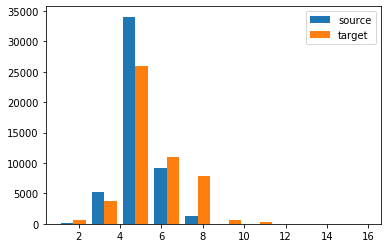

In [11]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist([[len(l) for l in source], [len(l) for l in target]], label=["source", "target"])
plt.legend(loc="upper right")

### 建立字典
`单词` → `id`的列表。

In [39]:
class Vocab_dict(object):
    """
    建立字典的语料库，单词级别。
    """
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        token_freqs = sorted(counter.items(), key=lambda x:x[0])
        token_freqs.sort(key=(lambda x:x[1]), reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0,1,2,3)
            tokens = ["<pad>","<bos>","<eos>","<unk>"]
        else:
            self.unk = 0
            tokens = ["<unk>"]
        tokens += [token for token, freq in token_freqs if freq >= min_freq]
        self.idx_to_token = []
        self.token_to_idx = dict()
        for token in tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, items):
        if not isinstance(items, (list, tuple)):
            return self.token_to_idx.get(items, self.unk)
        else:
            return [self.__getitem__(item) for item in items]
        
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [13]:
def build_vocab(tokens):
    """
    从字典建立语料库。
    :param tokens:
    :return:
    """
    tokens = [token for line in tokens for token in line]
    return nlp.Vocab_dict(tokens, min_freq=3, use_special_tokens=True)

In [14]:
src_vocab = build_vocab(source)
len(src_vocab)

3789

### 字符索引映射&长度补全

In [15]:
def pad(line, max_len, padding_token):
    """
    句子截断&补全。
    :param line: 分好词的句子。
    :param max_len: 最大长度。
    :param padding_token: 空白字符。
    :return: 
    """
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

In [16]:
def build_array(lines, vocab, max_len, is_source):
    """
    建立字典的每一行从token转换为idx。
    :param lines: 字典。
    :param vocab: 字典语料库。
    :param max_len: 句子最大长度。
    :param is_source: 是否标注起始、结束。
    :return: array, valid_len
    """
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(dim=1)
    return array, valid_len

In [17]:
def load_data_nmt(source, target, batch_size, max_len): 
    """
    生成机器翻译字典的批量数据。
    :param batch_size: 批量大小。
    :param max_len: 句子长度上线。
    :return: 迭代器
    """
    src_vocab, tgt_vocab = nlp.build_vocab(source), nlp.build_vocab(target)
    src_array, src_valid_len = nlp.build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = nlp.build_array(target, tgt_vocab, max_len, False)
    train_data = torch.utils.data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [18]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(source, target, batch_size=2, max_len=8)

In [19]:
for X, X_valid_len, Y, Y_valid_len, in train_iter:
    print('X =', X.type(torch.int32), '\nValid lengths for X =', X_valid_len,
        '\nY =', Y.type(torch.int32), '\nValid lengths for Y =', Y_valid_len)
    break

X = tensor([[ 195,   11,   10,   18,    4,    0,    0,    0],
        [  14,  213,   36,    7, 3233,    4,    0,    0]], dtype=torch.int32) 
Valid lengths for X = tensor([5, 6]) 
Y = tensor([[   1,    3,   13,    2,    0,    0,    0,    0],
        [   1,   11, 1102,   20,   27,    3,    4,    2]], dtype=torch.int32) 
Valid lengths for Y = tensor([4, 8])


## encoder-decoder
![encoder-decode结构](https://cdn.kesci.com/upload/image/q5jcat3c8m.png?imageView2/0/w/640/h/640)

- encoder：输入到隐藏状态
- decoder：隐藏状态到输出

In [20]:
class Encoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [21]:
class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [22]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## seq2seq
- 预测时decoder的输暑促和是下一步的输入。
- encoder的隐藏层状态传递给decoder。

### 模型训练  
![Image Name](https://cdn.kesci.com/upload/image/q5jc7a53pt.png?imageView2/0/w/640/h/640)

### 模型预测
![Image Name](https://cdn.kesci.com/upload/image/q5jcecxcba.png?imageView2/0/w/640/h/640)



### 具体结构：
输入先做embedding。

![Image Name](https://cdn.kesci.com/upload/image/q5jccjhkii.png?imageView2/0/w/500/h/500)

#### Encoder
本编码器以LSTM（`torch.nn.LSTM`）为基础：
- 输入X： (batch_size, seq_len, embed_size)；
- 输出Y： (seq_len, batch_size, num_hiddens)；
- LSTM的state： (num_layers, batch_size, num_hiddens)。
    - 隐藏状态
    - 记忆细胞，

In [23]:
class Seq2SeqEncoder(Encoder):
    """
    Encoder的具体实现。
    X shape: (batch_size, seq_len, embed_size)；
    Y shape: (seq_len, batch_size, num_hiddens)；
    LSTM的state包含最后一步的隐藏状态、记忆细胞，shape是 (num_layers, batch_size, num_hiddens)。
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.rnn = torch.nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def begin_state(self, batch_size, device):
        return [torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros(size=(self.num_layers, batch_size, self.num_hiddens), device=device)]

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        X = X.transpose(0, 1)  # RNN needs first axes to be time
        # state = self.begin_state(X.shape[1], device=X.device)
        out, state = self.rnn(X)
        return out, state

In [24]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

#### Decoder

In [25]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.rnn = torch.nn.LSTM(embed_size,num_hiddens, num_layers, dropout=dropout)
        self.dense = torch.nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).transpose(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).transpose(0, 1)
        return out, state

In [26]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

## 损失函数
仅在有效长度求损失

### 有效长度掩码

In [27]:
def SequenceMask(X, X_len,value=0):
    """
    对于不定长序列求损失函数，仅在有效长度进行。
    :param X: (batch_size, maxlen)每一行是一个序列数据。
    :param X_len: (batch_size,)有效长度。
    :param value: mask。
    :return: 
    """
    maxlen = X.size(1)
    mask = torch.arange(maxlen)[None, :].to(X_len.device) < X_len[:, None]   
    X[~mask]=value
    return X

In [28]:
X = torch.tensor([[1,2,3], [4,5,6]])
SequenceMask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

### 带掩码的损失函数

In [29]:
class MaskedSoftmaxCELoss(torch.nn.CrossEntropyLoss):
    """
    带掩码的交叉熵损失函数类。
    
    X shape: (batch_size, seq_len, vocab_size)
    y shape: (batch_size, seq_len)
    valid_length shape: (batch_size, )
    """
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len)
        weights = torch.ones_like(label)
        weights = SequenceMask(weights, valid_length).float()
        self.reduction='none'
        # (batch_size, vocab_size, seq_len) x (batch_size, seq_len) -> (batch_size, seq_len)
        output=super(MaskedSoftmaxCELoss, self).forward(pred.transpose(1,2), label)
        return (output*weights).mean(dim=1)

In [30]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones((3, 4, 10)), torch.ones((3,4),dtype=torch.long), torch.tensor([4,3,0]))

tensor([2.3026, 1.7269, 0.0000])

## 训练

In [31]:
def grad_clipping_nn(model, theta, device):
    grad_clipping(model.parameters(), theta, device)

In [32]:
def train_ch7(model, data_iter, lr, num_epochs, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    tic = time.time()
    for epoch in range(1, num_epochs + 1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen - 1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            l = loss(Y_hat, Y_label, Y_vlen).sum()
            l.backward()
            with torch.no_grad():
                rnn.grad_clipping(model.parameters(), 5, device)
            num_tokens = Y_vlen.sum().item()
            optimizer.step()
            
            l_sum += l.sum().item()
            num_tokens_sum += num_tokens
        if epoch % 50 == 0:
            print("epoch {0:4d},loss {1:.3f}, time {2:.1f} sec".format(
                epoch, (l_sum / num_tokens_sum), time.time() - tic))
            tic = time.time()

In [33]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_examples, max_len = 64, 1e3, 10

In [34]:
lr, num_epochs, ctx = 0.005, 300, basic.try_gpu()
src_vocab, tgt_vocab, train_iter = data.load_data_nmt(source, target, batch_size, max_len)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)

In [35]:
train_ch7(model, train_iter, lr, num_epochs, ctx)

epoch   50,loss 0.145, time 717.4 sec
epoch  100,loss 0.127, time 723.9 sec
epoch  150,loss 0.120, time 728.2 sec
epoch  200,loss 0.116, time 714.1 sec
epoch  250,loss 0.113, time 715.9 sec
epoch  300,loss 0.114, time 716.4 sec


## 测试

In [57]:
def translate_ch7(model, src_sentence, src_vocab, tgt_vocab, max_len, device):
    """
    机器翻译的enc-dec预测。
    :param model: encoder-decode模型。
    :param src_sentence: 待翻译语句。
    :param src_vocab: 源语言词典。
    :param tgt_vocab: 目标语言词典。
    :param max_len: 最大有效句子长度。
    :param device: CPU/GPU。
    :return: 翻译好的语句。
    """
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.tensor(src_tokens, device=device)
    enc_valid_length = torch.tensor([src_len], device=device)
    enc_outputs = model.encoder(enc_X.unsqueeze(dim=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.tensor([tgt_vocab.bos], device=device).unsqueeze(dim=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).int().item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return [src_vocab.idx_to_token[i] for i in predict_tokens]

In [63]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + " " + " ".join(translate_ch7(model, sentence, src_vocab, tgt_vocab, max_len, ctx)))

Go . <unk> i'm
Wow ! come be young what temporary .
I'm OK . i car me? .
I won ! don't often .


## 集束搜索
贪心搜搜，挑选较好的几个继续预测。

# 注意力机制及Seq2Seq模型

## 注意力机制
Attention 是一种通用的带权池化方法，输入由两部分构成：询问（query）和键值对（key-value pairs）。$𝐤_𝑖∈ℝ^{𝑑_𝑘}, 𝐯_𝑖∈ℝ^{𝑑_𝑣}$. Query  $𝐪∈ℝ^{𝑑_𝑞}$ , attention layer得到输出与value的维度一致 $𝐨∈ℝ^{𝑑_𝑣}$. 对于一个query来说，attention layer 会与每一个key计算注意力分数并进行权重的归一化，输出的向量$o$则是value的加权求和，而每个key计算的权重与value一一对应。

为了计算输出，我们首先假设有一个函数$\alpha$ 用于计算query和key的相似性，然后可以计算所有的 attention scores $a_1, \ldots, a_n$ by


$$
a_i = \alpha(\mathbf q, \mathbf k_i).
$$


我们使用 softmax函数 获得注意力权重：


$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).
$$


最终的输出就是value的加权求和：


$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.
$$


![Image Name](https://cdn.kesci.com/upload/image/q5km4ooyu2.PNG?imageView2/0/w/960/h/960)

注意力机制的不一样在于$a_i = \alpha(\mathbf q, \mathbf k_i)$不同，常见的注意层有
- `Dot-product Attention`
- `Multilayer Perceptron Attention`

`torch.bmm()`：batch matric multiply

In [64]:
def SequenceMask(X, X_len,value=-1e6):
    maxlen = X.size(1)
    #print(X.size(),torch.arange((maxlen),dtype=torch.float)[None, :],'\n',X_len[:, None] )
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] >= X_len[:, None]   
    #print(mask)
    X[mask]=value
    return X

In [75]:
def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = torch.nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))#[2,2,3,3]
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1], axis=0))#[2,2,3,3]
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
 
        return softmax(X).reshape(shape)

## 点积注意力
The dot product 假设query和keys有相同的维度, 即 $\forall i, 𝐪,𝐤_𝑖 ∈ ℝ_𝑑 $. 通过计算query和key转置的乘积来计算attention score,通常还会除去 $\sqrt{d}$ 减少计算出来的score对维度𝑑的依赖性，如下


$$
𝛼(𝐪,𝐤)=⟨𝐪,𝐤⟩/ \sqrt{d} 
$$

假设 $ 𝐐∈ℝ^{𝑚×𝑑}$ 有 $m$ 个query，$𝐊∈ℝ^{𝑛×𝑑}$ 有 $n$ 个keys. 我们可以通过矩阵运算的方式计算所有 $mn$ 个score：


$$
𝛼(𝐐,𝐊)=𝐐𝐊^𝑇/\sqrt{d}
$$
 
现在让我们实现这个层，它支持一批查询和键值对。此外，它支持作为正则化随机删除一些注意力权重.

`torch.bmm`

In [76]:
class DotProductAttention(torch.nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = torch.nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        print("attention_weight\n",attention_weights)
        return torch.bmm(attention_weights, value)

In [77]:
atten = DotProductAttention(dropout=0)

keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))

attention_weight
 tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

In [78]:
keys.shape, values.shape

(torch.Size([2, 10, 2]), torch.Size([2, 10, 4]))

## 多层感知机注意力层
在多层感知器中，我们首先将 query and keys 投影到  $ℝ^ℎ$ .为了更具体，我们将可以学习的参数做如下映射 
$𝐖_𝑘∈ℝ^{ℎ×𝑑_𝑘}$ ,  $𝐖_𝑞∈ℝ^{ℎ×𝑑_𝑞}$ , and  $𝐯∈ℝ^h$ . 将score函数定义
$$
𝛼(𝐤,𝐪)=𝐯^𝑇tanh(𝐖_𝑘𝐤+𝐖_𝑞𝐪)
$$
. 
然后将key 和 value 在特征的维度上合并（concatenate），然后送至 a single hidden layer perceptron 这层中 hidden layer 为  ℎ  and 输出的size为 1 .隐层激活函数为tanh，无偏置。

尽管MLPAttention包含一个额外的MLP模型，但如果给定相同的输入和相同的键，我们将获得与DotProductAttention相同的输出。

**在Dot-product Attention中，key与query维度需要一致，在MLP Attention中则不需要。**

In [79]:
# Save to the d2l package.
class MLPAttention(torch.nn.Module):  
    def __init__(self, units,ipt_dim,dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=True to keep query's and key's 3-D shapes.
        self.W_k = torch.nn.Linear(ipt_dim, units, bias=False)
        self.W_q = torch.nn.Linear(ipt_dim, units, bias=False)
        self.v = torch.nn.Linear(units, 1, bias=False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length):
        query, key = self.W_k(query), self.W_q(key)
        #print("size",query.size(),key.size())
        # expand query to (batch_size, #querys, 1, units), and key to
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.
        features = query.unsqueeze(2) + key.unsqueeze(1)
        #print("features:",features.size())  #--------------开启
        scores = self.v(features).squeeze(-1) 
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

In [80]:
atten = MLPAttention(ipt_dim=2,units = 8, dropout=0)
atten(torch.ones((2,1,2), dtype = torch.float), keys, values, torch.FloatTensor([2, 6]))

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward>)

## seq2seq with attention



![带注意力的seq2seq](https://cdn.kesci.com/upload/image/q5km8dihlr.PNG?imageView2/0/w/800/h/800)


decoder输出作为注意力层的query，encoder输出作为注意力层的输入。

# Transformer

- CNNs 易于并行化，却不适合捕捉变长序列内的依赖关系。
- RNNs 适合捕捉长距离变长序列的依赖，但是却难以实现并行化处理序列。

Transformer同样基于编码器-解码器架构，其区别主要在于以下三点：
1. Transformer blocks：将seq2seq模型重的循环网络替换为了Transformer Blocks，该模块包含一个多头注意力层（Multi-head Attention Layers）以及两个position-wise feed-forward networks（FFN）。对于解码器来说，另一个多头注意力层被用于接受编码器的隐藏状态。
2. Add and norm：多头注意力层和前馈网络的输出被送到两个“add and norm”层进行处理，该层包含残差结构以及层归一化。
3. Position encoding：由于自注意力层并没有区分元素的顺序，所以一个位置编码层被用于向序列元素里添加位置信息。

![Fig. 10.3.1 The Transformer architecture.](https://cdn.kesci.com/upload/image/q5kpbj2cj5.png?imageView2/0/w/960/h/960)



## Transfomer Block

## Add and norm

## Position encoding